# Introduction

How consistent are the means of our replicates? MAD is designed with the asumption they are different.

In [1]:
import pandas
import collections
import sys
import os
import numpy
import pprint
import time

ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if ROOT not in sys.path:
    sys.path.append(ROOT)
import save_rnaseq_madqc

In [44]:
from matplotlib import pylab
pylab.style.use('ggplot')

In [40]:
%matplotlib inline

In [2]:
query_url = 'search/?type=experiment&assay_term_name=RNA-seq'
cache_name = os.path.join(ROOT, 'rnaseq-experiments.shelf')
cache = save_rnaseq_madqc.caching_encoded_experiment_loader(query_url, cache_name)

Reading 140 of 1408 records in 15.895706210998469 seconds
Reading 280 of 1408 records in 29.262944126996445 seconds
Reading 420 of 1408 records in 17.184238300003926 seconds
Reading 560 of 1408 records in 22.024000501995033 seconds
Reading 700 of 1408 records in 38.80602922500111 seconds
Reading 840 of 1408 records in 36.341432588000316 seconds
Reading 980 of 1408 records in 40.48364093200507 seconds
Reading 1120 of 1408 records in 44.05076729999564 seconds
Reading 1260 of 1408 records in 42.82476692300406 seconds
Reading 1400 of 1408 records in 40.72936621099507 seconds
Read 1408 records in 327.60289231899515 seconds


In [3]:
def filter_experiments_by_size(cache):
    for i, experiment_id in enumerate(cache):
        experiment = cache[experiment_id]
        for replicate in experiment['replicates']:
            library = replicate['library']

            starting_amount = float(library.get('nucleic_acid_starting_quantity', numpy.nan))
            starting_amount_units = library.get('nucleic_acid_starting_quantity_units')
            if starting_amount >= 10 and starting_amount_units == 'ng':
                yield experiment_id

In [4]:
len(list(filter_experiments_by_size(cache)))

207

In [5]:
def filter_experiments_by_13pg(cache):
    for i, experiment_id in enumerate(cache):
        experiment = cache[experiment_id]
        for replicate in experiment['replicates']:
            library = replicate['library']

            starting_amount = float(library.get('nucleic_acid_starting_quantity', numpy.nan))
            starting_amount_units = library.get('nucleic_acid_starting_quantity_units')
            if starting_amount == 13 and starting_amount_units == 'pg':
                yield experiment_id

In [6]:
len(list(filter_experiments_by_13pg(cache)))

22

In [7]:
def load_spike_rsems(cache, keys, limit=None):
    keys = list(keys)
    total = len(keys)
    chunk = max(total // 10, 1)
    tzero = time.monotonic()
    tprev = tzero
    
    for i, experiment_id in enumerate(keys):
        experiment = cache[experiment_id]
        fpkms = []
        for file in save_rnaseq_madqc.find_rsem(experiment['files']):
            url = 'https://www.encodeproject.org' + file.href
            fpkm = pandas.read_csv(url, usecols=[0,6], sep='\t', index_col=0)
            fpkm.columns = [file.library_id]
            fpkms.append(fpkm)

        if fpkms:
            yield (experiment_id, pandas.concat(fpkms, axis=1))
            
        if (i + 1) % chunk == 0:
            tnow = time.monotonic()
            print("{} of {} in {:.2f} sec".format(
                i, total, tnow-tprev))
            tprev = tnow

        if limit and i > limit:
            return

In [27]:
def mad_filter(matrix):
    nonzero = fpkms[fpkms > 0].dropna(how='any')
    logmatrix = numpy.log2(nonzero)
    A = (logmatrix.iloc[:,0] + logmatrix.iloc[:,1]) / 2
    return logmatrix[A > 0]

In [39]:
similarity = []
for experiment_id, fpkms in load_spike_rsems(cache,
                                            filter_experiments_by_size(cache)):
    filtered = mad_filter(fpkms).mean()
    difference = numpy.abs(filtered[0] - filtered[1])
    similarity.append(difference)

19 of 207 in 35.81 sec
39 of 207 in 33.50 sec
59 of 207 in 31.82 sec
79 of 207 in 39.69 sec
99 of 207 in 43.12 sec
119 of 207 in 38.49 sec
139 of 207 in 21.40 sec
159 of 207 in 25.85 sec
179 of 207 in 34.61 sec
199 of 207 in 40.07 sec


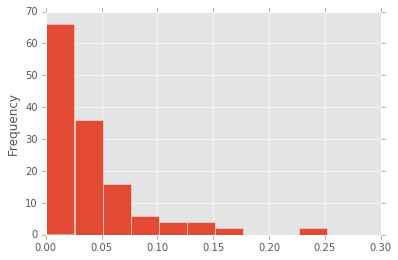

In [45]:
pandas.Series(similarity).plot(kind='hist')

In [46]:
similarity_13pg = []
for experiment_id, fpkms in load_spike_rsems(
      cache,
      keys=filter_experiments_by_13pg(cache)
    ):
    filtered = mad_filter(fpkms).mean()
    difference = numpy.abs(filtered[0] - filtered[1])
    similarity_13pg.append(difference)

1 of 22 in 4.36 sec
3 of 22 in 5.03 sec
5 of 22 in 4.88 sec
7 of 22 in 4.66 sec
9 of 22 in 7.23 sec
11 of 22 in 6.94 sec
13 of 22 in 7.66 sec
15 of 22 in 7.21 sec
17 of 22 in 5.54 sec
19 of 22 in 4.83 sec
21 of 22 in 5.01 sec


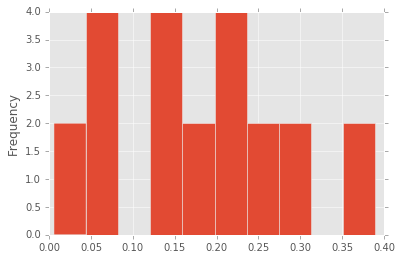

In [47]:
pandas.Series(similarity_13pg).plot(kind='hist')

In [48]:
2 ** 3.0

8.0

In [49]:
2 ** 3.5

11.313708498984761